**HPGe Timing: GridSearch**

In [1]:
# Check if there is GPU
import tensorflow as tf
# from tensorflow.python.client.device_lib import list_local_devices
from tensorflow.config import list_physical_devices

# print(list_local_devices())
print("Num GPUs Available: ", len(list_physical_devices('GPU')))
list_physical_devices()

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

# One detector

## Import libraries and data pre-processing

### Import libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import statistics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Conv1D, Flatten,MaxPooling1D, Reshape, UpSampling1D, Conv2DTranspose
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.utils import plot_model  # for plotting the model structure
from sklearn.preprocessing import StandardScaler 
#import np_utils

import h5py

import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

%matplotlib notebook
%matplotlib inline



---


## Waveform training set


Read data

In [4]:
eLow=500 # kEV
eHigh=1000
t0max=280
# t0offset=130 #shift t0 close to the onset of the waveform, don`t know if it matters

length=300

channels = [4,5,6,7,8,9,10]
data = {}
for ch in channels:
    data[ch]={}
    
data[4]["name"]="Ge2"
data[5]["name"]="Ge3"
data[6]["name"]="Ge4"
data[7]["name"]="Ge5"
data[8]["name"]="Ge6"
data[9]["name"]="Ge7"
data[10]["name"]="Ge8"
#data[11]["name"]="Ge9"
#data[12]["name"]="Ge10"

Export data from ROOT to h5py

In [ ]:
# hf = h5py.File('HPGe_data_Ext_low_en.h5', 'w')

# for ch in channels:
#   print(f"Ge{ch}", end=" ")
#   g = hf.create_group(f"Ge{ch}")
#   g.create_dataset("energy", data= data[ch]["energy"])
#   g.create_dataset("time", data= data[ch]["time"])
#   g.create_dataset("samples", data= data[ch]["samples"])
#   g.create_dataset("time0", data=data[ch]["time0"])

# hf.close()

Read data from .h5

In [5]:
hf = h5py.File('data/HPGe_data_Ext_low_en.h5', 'r')

print(list(hf.keys()))
total_entries = 0

for ch in channels:
  group = hf.get(f"Ge{ch}")

  data[ch]["energy"] = np.array(group.get("energy"))
  data[ch]["time0"] = np.array(group.get("time0"))
  data[ch]["time"] = np.array(group.get("time"))
  data[ch]["samples"] = np.array(group.get("samples"))
  total_entries += data[ch]["time0"].shape[0]
  
hf.close()

print(total_entries)

['Ge10', 'Ge4', 'Ge5', 'Ge6', 'Ge7', 'Ge8', 'Ge9']
828223


## Data prep

Plot of t0 (low energies: 500 - 100 kEv)

Ge2: mean=155.8914235511527 std=10.753658421154173 #:132036
Ge3: mean=146.31143924907363 std=8.703360277516097 #:126031
Ge4: mean=156.45462063679363 std=7.188830516340221 #:99153
Ge5: mean=163.90920857824233 std=8.243773216669368 #:112797
Ge6: mean=157.44418309930552 std=8.319306628406263 #:98635
Ge7: mean=154.26840296617834 std=7.790785886383462 #:138225
Ge8: mean=158.5916635076558 std=9.035206269990459 #:121346


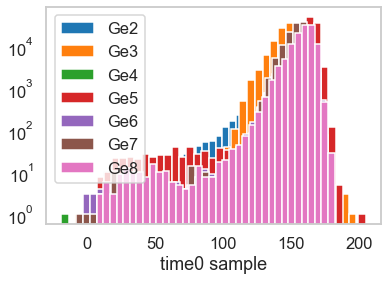

In [6]:
plt.grid()
for ch in channels:
    if ch != 10:
        #continue
        pass
    plt.hist(data[ch]["time0"],bins=36,label=data[ch]["name"])
    #plt.hist(data[ch]["time0"]+100,bins=36,label=data[ch]["name"])
    print(data[ch]["name"] + ": mean=" + str(np.mean(data[ch]["time0"])) + " std=" + str(np.std(data[ch]["time0"])) + " #:" + str(len(data[ch]["time0"])))
#plt.hist(data[8]["time0"],bins=40)
plt.xlabel("time0 sample")
plt.legend()
plt.yscale("log")
plt.show()

**Select the data**

Analize only a set of channels

In [7]:
analyze_these_channels = [9]
print("Use these detectors as thraining data: " )
for ch in analyze_these_channels:
    print(data[ch]["name"])

X = np.array(data[analyze_these_channels[0]]["samples"])
y = np.array(data[analyze_these_channels[0]]["time0"])
X.shape, y.shape

Use these detectors as thraining data: 
Ge7


((138225, 300), (138225,))

In [8]:
for ch in analyze_these_channels:
    if ch == analyze_these_channels[0]:
        continue
    X = np.concatenate((X,data[ch]["samples"]))
    y = np.concatenate((y,data[ch]["time0"]))
X.shape, y.shape

((138225, 300), (138225,))

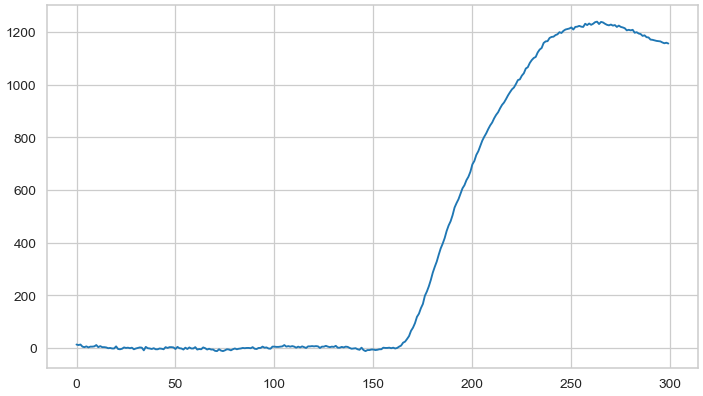

In [8]:
fig = plt.figure(figsize=(14, 8),dpi= 60)
for x in range(0,1):
    plt.plot(X[x])
    # plt.yscale("log")

### Split and scaling the data

Dataset splitting::
* 64% - training, 16% - validation (model fit)
* 20% - test (model evaluation)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

np.random.seed(9)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

Scale features



In [10]:
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler

normalizer = None 

def scale_feature(feature, fit=False):
    global normalizer
    # Reshape for normalizing relative to global max
    feature_serial = feature.reshape((feature.shape[0]*feature.shape[1],1))
    
    if fit: normalizer = MinMaxScaler().fit(feature_serial)
        
    feature_serial = normalizer.transform(feature_serial)
    feature_norm = feature_serial.reshape(feature.shape)
    
    return feature_norm

In [11]:
X_train_norm = scale_feature(X_train, fit=True)
X_train_norm.shape

(88464, 300)

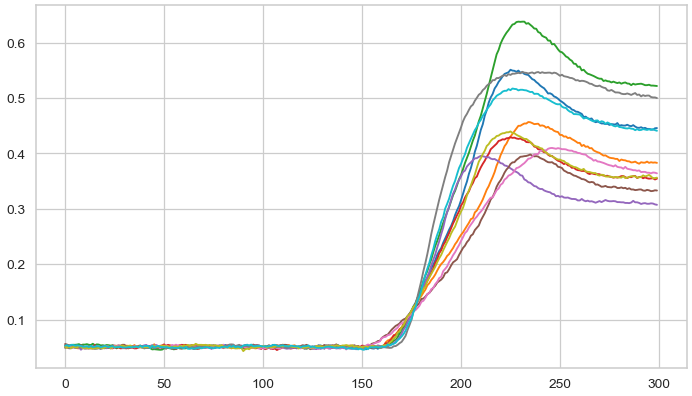

In [12]:
fig = plt.figure(figsize=(14, 8),dpi= 60)
for x in range(0,10):
    plt.plot(X_train_norm[x])

In [13]:
X_test_norm = scale_feature(X_test)
X_valid_norm = scale_feature(X_valid)

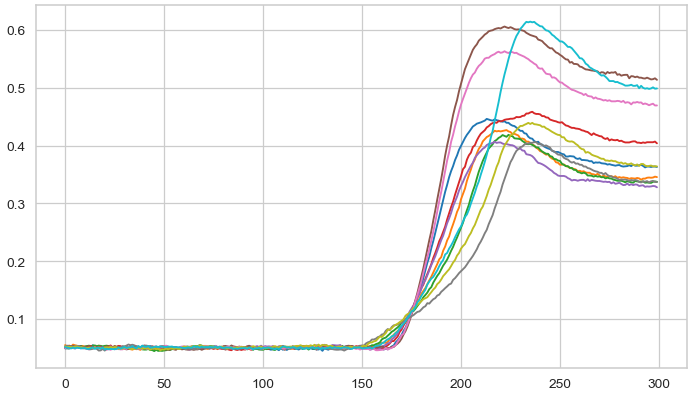

In [14]:
fig = plt.figure(figsize=(14, 8),dpi= 60)
for x in range(0,10):
    plt.plot(X_test_norm[x])

## Autoencoder model

### Define model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Conv1D ,MaxPooling1D, AveragePooling1D, UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Input  
from tensorflow.nn import selu
import tensorflow as tf

from tensorboard.plugins.hparams import api as hp

# Callback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [16]:
HP_KERN_SIZE = hp.HParam('kern_size', hp.Discrete([7, 11, 15]))
HP_NUM_FILT = hp.HParam('num_filters', hp.Discrete([10, 20, 30]))


METRIC = 'val_loss'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_KERN_SIZE, HP_NUM_FILT],
    metrics=[hp.Metric(METRIC, display_name='val_loss')],
  )

In [17]:
# kern_siz = 11 # semms to the best value, for all laters
# n_filt = 20  # worse with n_filt~15, also no sense to icnrease
l = 'mse'

kernel_init =initializer = tf.keras.initializers.HeNormal()  # tf.keras.initializers.GlorotNormal(seed=9)


def encoder_def(hparams, nDimInput=length):
    kern_siz = hparams[HP_KERN_SIZE]
    n_filt = hparams[HP_NUM_FILT]
    
    enc_in = Input(shape=(300,), name="original_sign")
    resh = Reshape(target_shape=(300,1))(enc_in)
    cnv1 = Conv1D(filters=n_filt, kernel_size=kern_siz, padding='same', activation='relu', kernel_initializer=kernel_init)(resh)
    avg1 = AveragePooling1D(pool_size=3)(cnv1)
    cnv2 = Conv1D(filters=n_filt, kernel_size=kern_siz, padding='same', activation='relu', kernel_initializer=kernel_init)(avg1)
    avg2 = AveragePooling1D(pool_size=2)(cnv2)
    cnv3 = Conv1D(filters=n_filt, kernel_size=kern_siz, padding='same', activation='relu', kernel_initializer=kernel_init)(avg2)
    cnv4 = Conv1D(filters=1, kernel_size=kern_siz, activation='relu', kernel_initializer=kernel_init,padding='same')(cnv3)
    flat = Flatten()(cnv4)
    enc_out = Dense(40,activation='relu', kernel_initializer=kernel_init)(flat)
    
    model = Model(enc_in, enc_out, name="encoder")
    model.compile(optimizer='Adam', loss=l)
    return model


def decoder_def(nDimOutput=length):
    kern_siz = hparams[HP_KERN_SIZE]
    n_filt = hparams[HP_NUM_FILT]
    
    dec_in = Input(shape=(40,), name="encoder_sign")
    dens = Dense(50, activation='relu', kernel_initializer=kernel_init)(dec_in)
    resh = Reshape(target_shape=(50,1))(dens)
    cnT1 = Conv1DTranspose(filters=1, kernel_size=kern_siz, padding="same", kernel_initializer=kernel_init, activation="relu")(resh)
    cnT2 = Conv1DTranspose(filters=n_filt, kernel_size=kern_siz, padding="same", kernel_initializer=kernel_init, activation="relu")(cnT1)
    ups1 = UpSampling1D(2)(cnT2)
    cnT3 = Conv1DTranspose(filters=n_filt, kernel_size=kern_siz, padding="same", kernel_initializer=kernel_init, activation="relu")(ups1)
    ups2 = UpSampling1D(3)(cnT3)
    cnT4 = Conv1DTranspose(filters=n_filt, kernel_size=kern_siz, padding="same", kernel_initializer=kernel_init, activation="relu")(ups2)
    cnT5 = Conv1DTranspose(filters=1, kernel_size=kern_siz, padding="same", kernel_initializer=kernel_init, activation="relu")(cnT4)
    dec_out = Flatten()(cnT5)
    
    model = Model(dec_in, dec_out, name="decoder")
    model.compile(optimizer='Adam', loss=l)
    return model


def autoencoder_def(encoder, decoder):
    autoenc_input = Input(shape=(300,), name="sign")
    encoded_sign = encoder(autoenc_input)
    decoded_sign = decoder(encoded_sign)
    model = Model(autoenc_input, decoded_sign, name="autoencoder")
    model.compile(loss=l, optimizer='adam', metrics=['mae']) 
    return model

def train_test_model(run_dir, hparams):
    np.random.seed(0)
    tf.random.set_seed(0)
    
    encoder_model = encoder_def(hparams)
    decoder_model = decoder_def(hparams)
    
    autoenc_input = Input(shape=(300,), name="sign")
    encoded_sign = encoder_model(autoenc_input)
    decoded_sign = decoder_model(encoded_sign)
    model = Model(autoenc_input, decoded_sign, name="autoencoder")
    model.compile(loss=l, optimizer='adam', metrics=['mae'])
    
    log_metrics = tf.keras.callbacks.TensorBoard(run_dir)
    log_hparams = hp.KerasCallback(run_dir, hparams)
    early_stop = EarlyStopping(monitor='val_loss', patience=30)
    batch_s = 128
    history = model.fit(X_train_norm, X_train_norm, batch_size=batch_s, epochs=300, 
                                validation_data=(X_valid_norm, X_valid_norm), validation_batch_size=batch_s, 
                                callbacks=[log_metrics, log_hparams, early_stop])
    return history
    
    

## Run GridSearch

In [18]:
# import shutil

# shutil.rmtree(r'logs/hparam_tuning/40_neur_bottle/run-0')

In [19]:
import shutil

session_num = 0
runs_history = list()
model_stuck = 0

for kernel_size in HP_KERN_SIZE.domain.values:
    for num_filters in HP_NUM_FILT.domain.values:
        hparams = {
            HP_KERN_SIZE: kernel_size,
            HP_NUM_FILT: num_filters,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        history = train_test_model('logs/hparam_tuning/40_neur_bottle/' + run_name, hparams)
        
        while len(history.history['loss']) < 50:
            model_stuck += 1
            shutil.rmtree(r'logs/hparam_tuning/40_neur_bottle/' + run_name)
            history = train_test_model('logs/hparam_tuning/40_neur_bottle/' + run_name, hparams)
            
        runs_history.append(history.history)
        
        session_num += 1

--- Starting trial: run-0
{'kern_size': 7, 'num_filters': 10}
Epoch 1/300
692/692 [==============================] - 50s 65ms/step - loss: 0.0018 - mae: 0.0158 - val_loss: 8.8263e-05 - val_mae: 0.0057
Epoch 2/300
692/692 [==============================] - 39s 56ms/step - loss: 6.6752e-05 - mae: 0.0050 - val_loss: 5.0862e-05 - val_mae: 0.0044
Epoch 3/300
692/692 [==============================] - 38s 55ms/step - loss: 3.7821e-05 - mae: 0.0039 - val_loss: 2.9098e-05 - val_mae: 0.0035
Epoch 4/300
692/692 [==============================] - 38s 55ms/step - loss: 2.9356e-05 - mae: 0.0035 - val_loss: 3.0712e-05 - val_mae: 0.0037
Epoch 5/300
692/692 [==============================] - 36s 52ms/step - loss: 2.4102e-05 - mae: 0.0032 - val_loss: 1.9113e-05 - val_mae: 0.0029
Epoch 6/300
692/692 [==============================] - 36s 51ms/step - loss: 2.1569e-05 - mae: 0.0031 - val_loss: 2.7575e-05 - val_mae: 0.0035
Epoch 7/300
692/692 [==============================] - 38s 55ms/step - loss: 1.9520e

In [20]:
model_stuck

0

### 40 neurons on the bottlneck

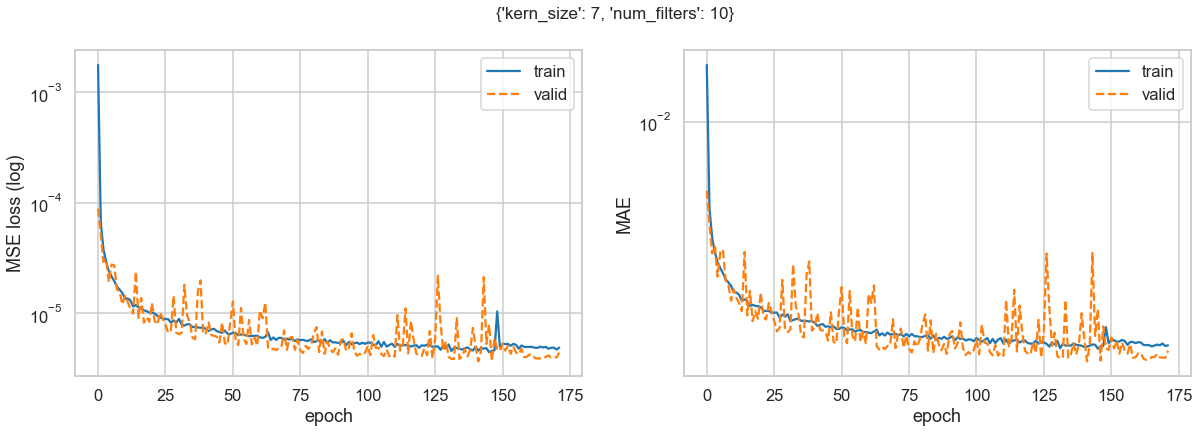

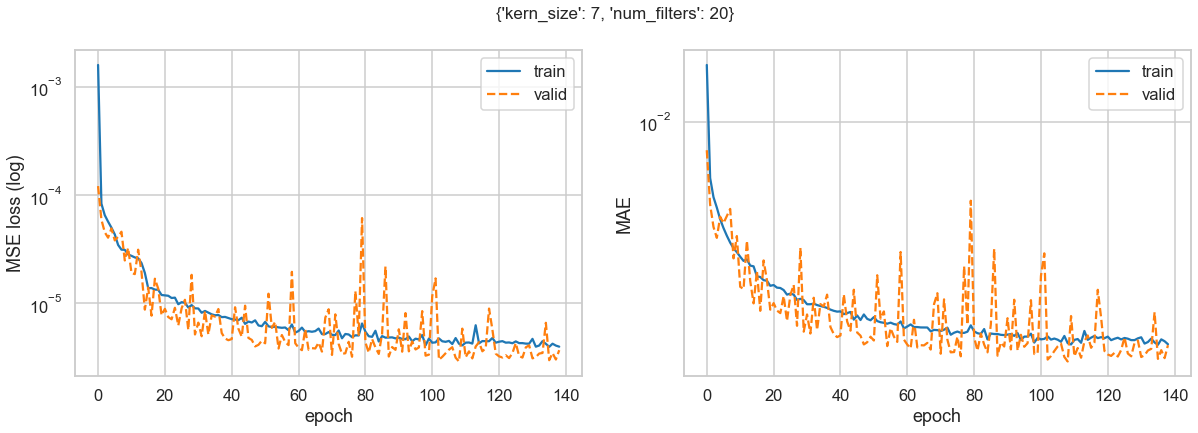

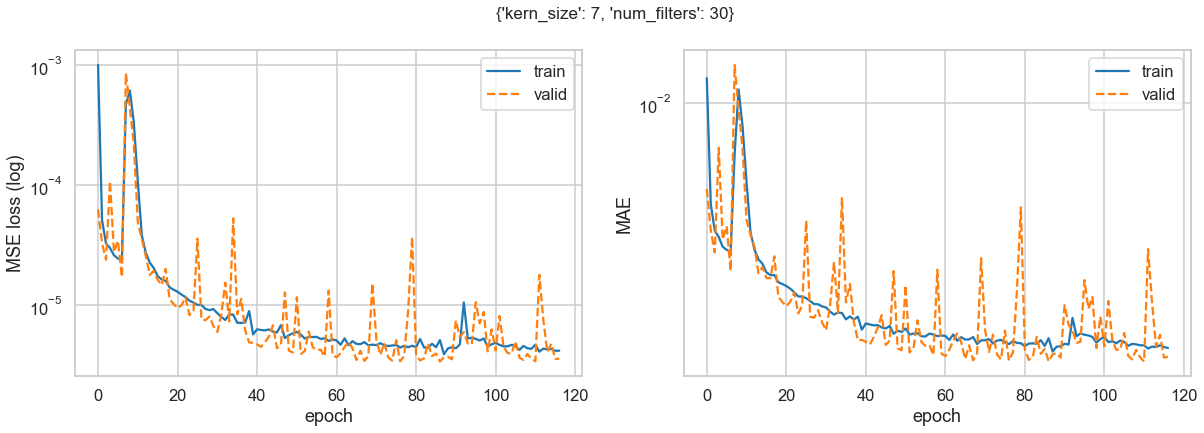

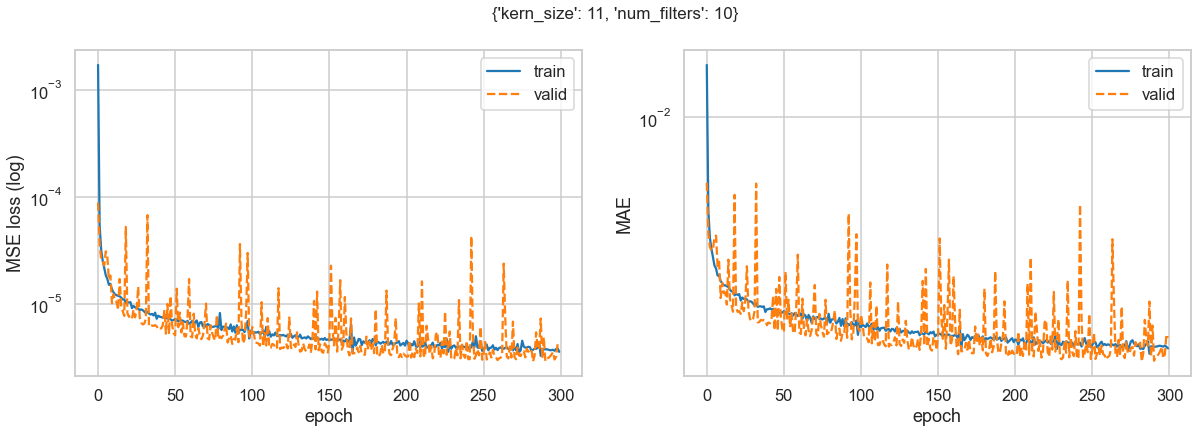

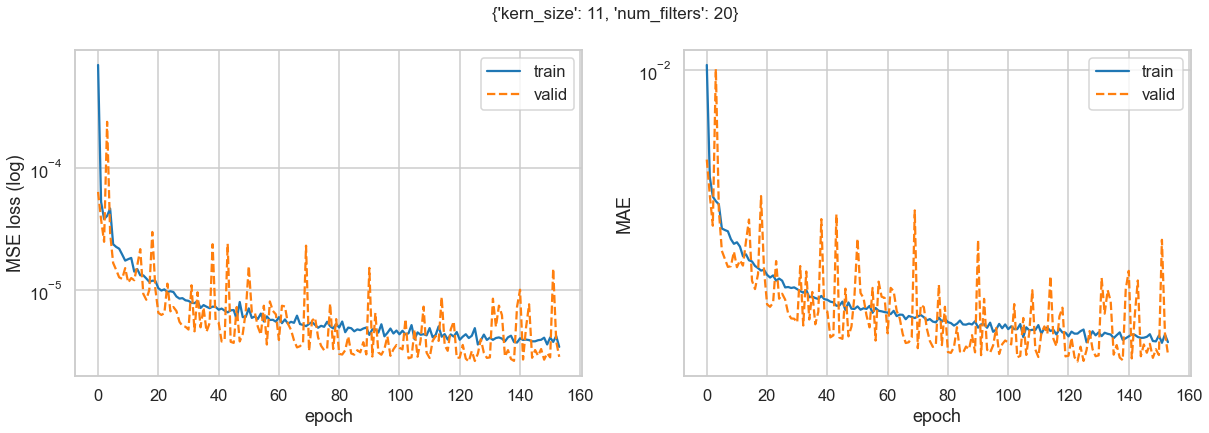

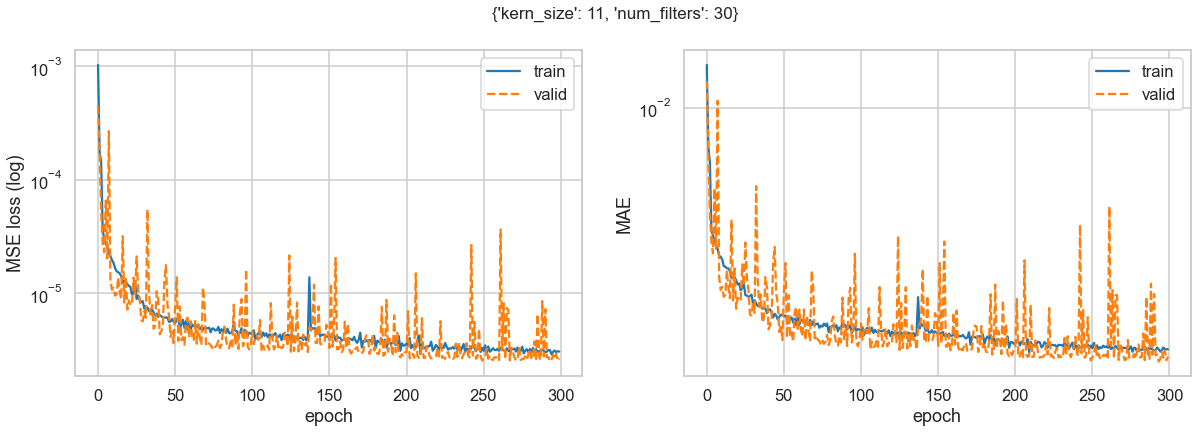

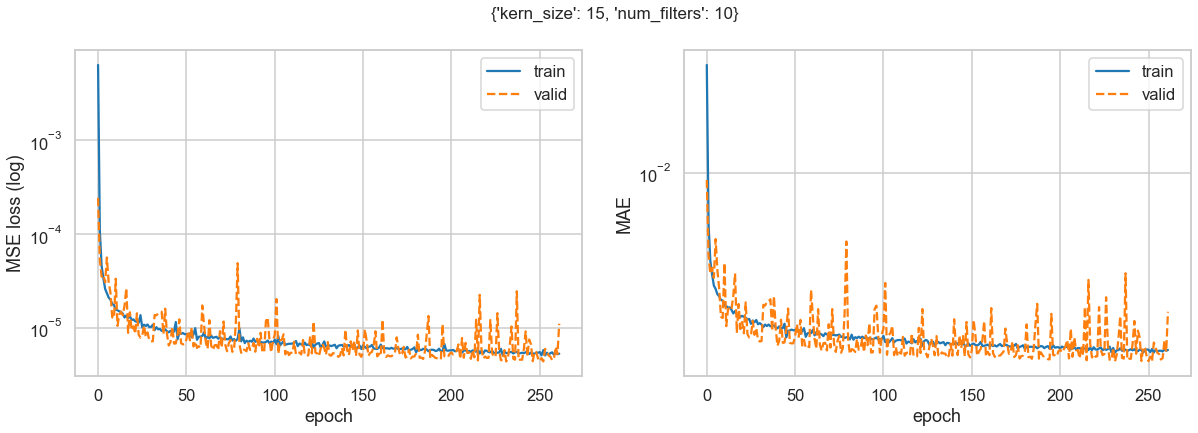

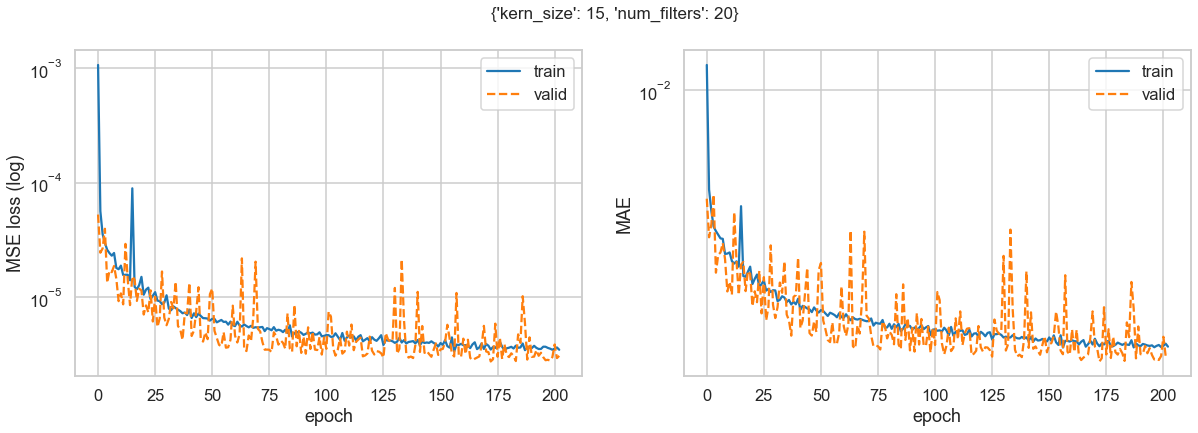

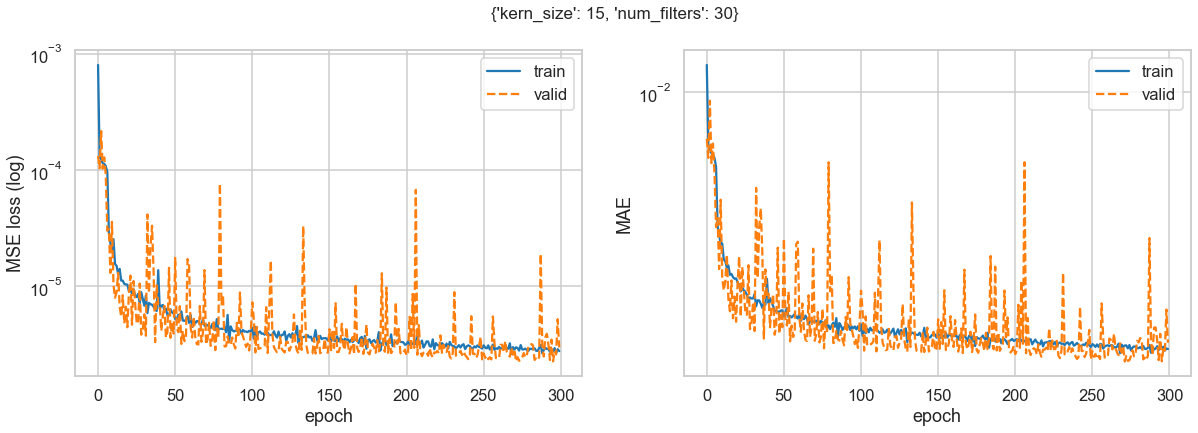

In [21]:
i=0
for kernel_size in HP_KERN_SIZE.domain.values:
    for num_filters in HP_NUM_FILT.domain.values:
        hparams = {
            HP_KERN_SIZE: kernel_size,
            HP_NUM_FILT: num_filters,
        }
        
        run_name = {h.name: hparams[h] for h in hparams}
        history = runs_history[i]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
        fig.suptitle(run_name, size=17)

        ax1.set_yscale("log")
        ax1.plot(history['loss'])
        ax1.plot(history['val_loss'], '--')
        ax1.set_ylabel('MSE loss (log)')
        ax1.set_xlabel('epoch')
        ax1.legend(['train', 'valid'], loc='upper right')

        ax2.set_yscale("log")
        ax2.plot(history['mae'])
        ax2.plot(history['val_mae'], '--')
        ax2.set_ylabel('MAE')
        ax2.set_xlabel('epoch')
        ax2.legend(['train', 'valid'], loc='upper right')
        i+=1

### 50 neurons on the bottlneck

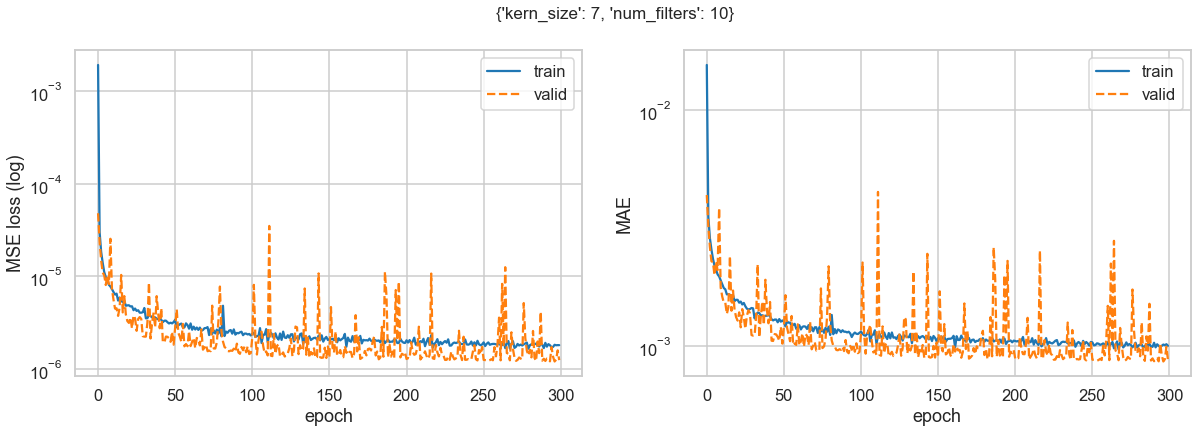

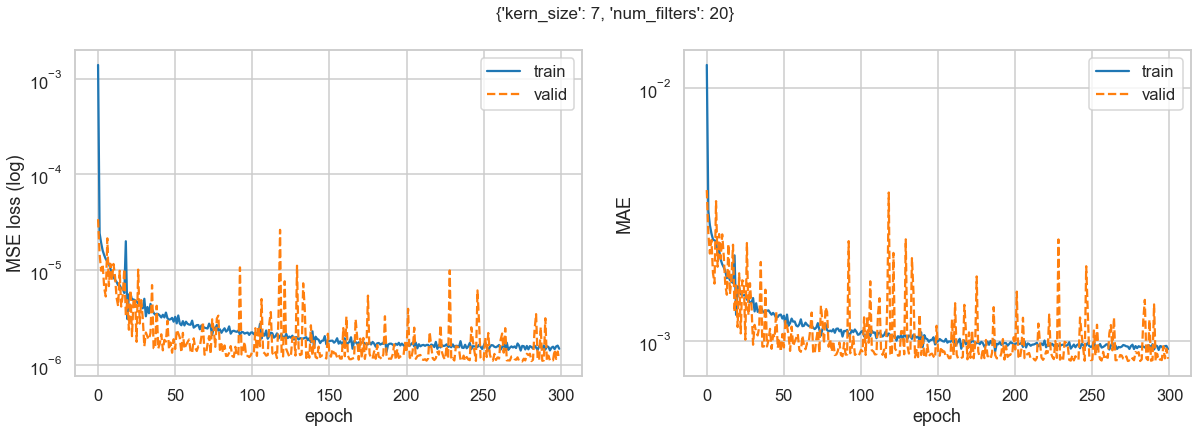

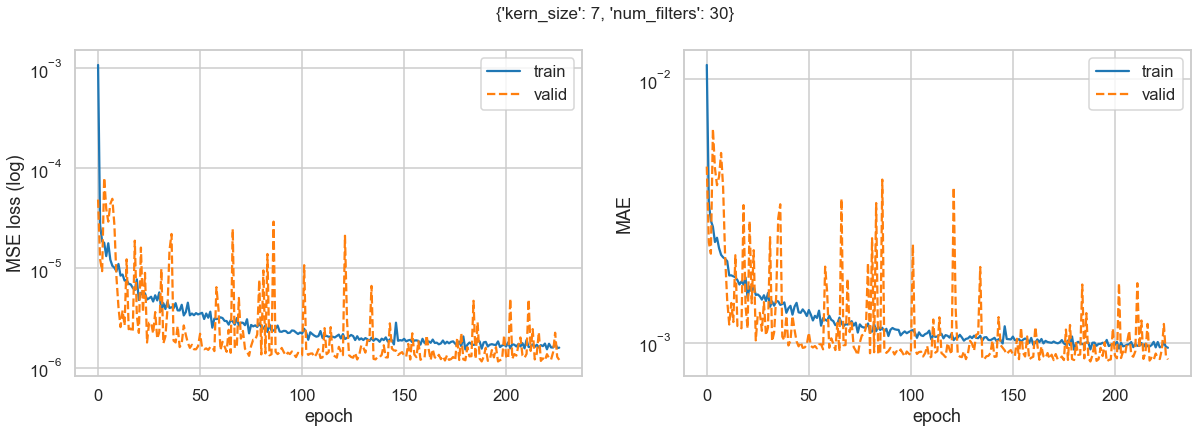

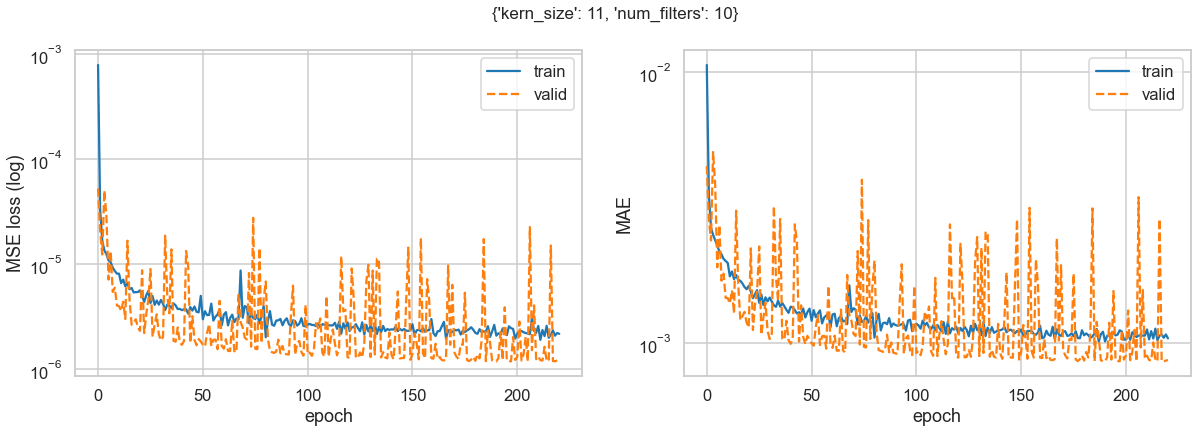

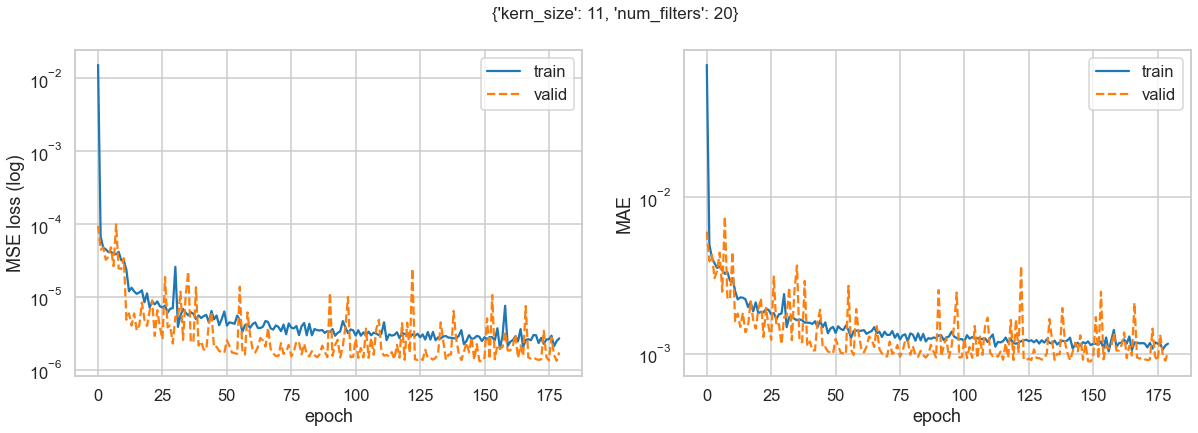

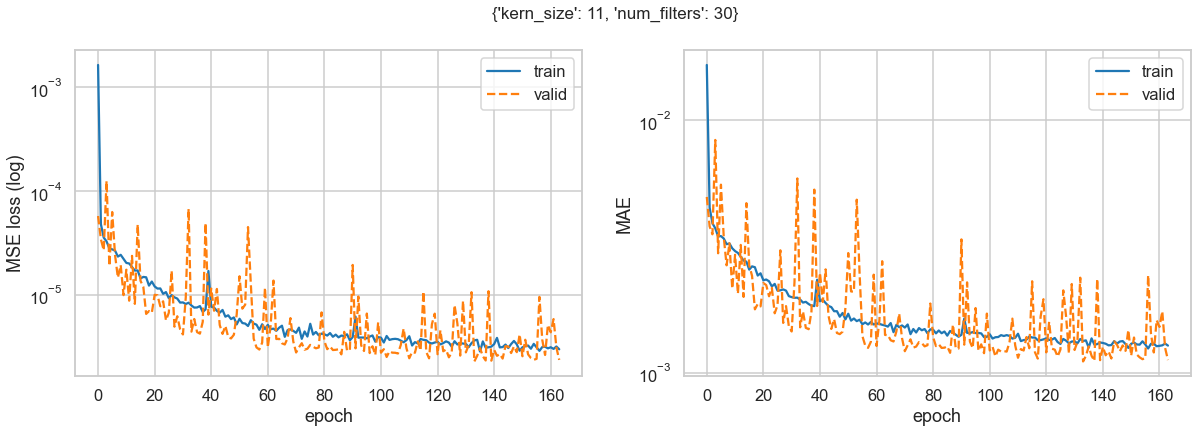

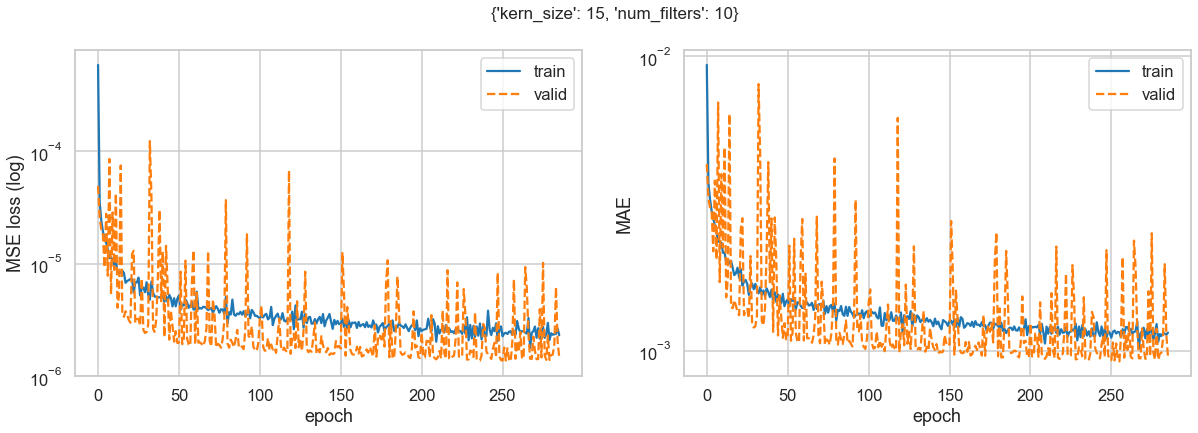

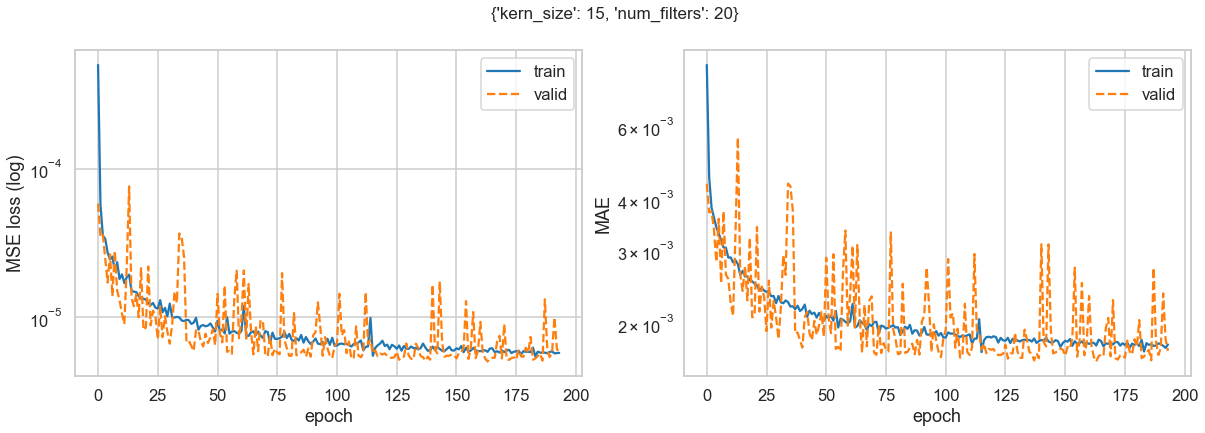

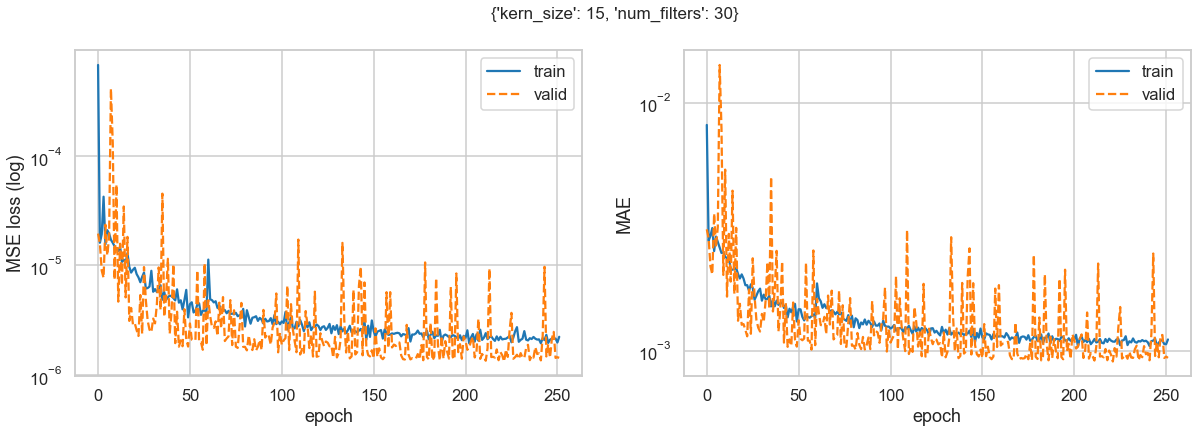

In [22]:
i=0
for kernel_size in HP_KERN_SIZE.domain.values:
    for num_filters in HP_NUM_FILT.domain.values:
        hparams = {
            HP_KERN_SIZE: kernel_size,
            HP_NUM_FILT: num_filters,
        }
        
        run_name = {h.name: hparams[h] for h in hparams}
        history = runs_history[i]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
        fig.suptitle(run_name, size=17)

        ax1.set_yscale("log")
        ax1.plot(history['loss'])
        ax1.plot(history['val_loss'], '--')
        ax1.set_ylabel('MSE loss (log)')
        ax1.set_xlabel('epoch')
        ax1.legend(['train', 'valid'], loc='upper right')

        ax2.set_yscale("log")
        ax2.plot(history['mae'])
        ax2.plot(history['val_mae'], '--')
        ax2.set_ylabel('MAE')
        ax2.set_xlabel('epoch')
        ax2.legend(['train', 'valid'], loc='upper right')
        i+=1

## Tensorboard

In [ ]:
%tensorboard --logdir logs/hparam_tuning/

In [24]:
!kill 7636

'kill' is not recognized as an internal or external command,
operable program or batch file.


In [22]:
print({h.name: hparams[h] for h in hparams})
print({h.name: hparams[h] for h in hparams})

{'kern_size': 15, 'num_filters': 30}
{'kern_size': 15, 'num_filters': 30}
